# FlyGenius Flight Time Modeling v.2

FlyGenius is undergoing a major update from the first version. We're going to be using the same dataset, but redesign the prediction process. In the previous version, we used a regression method to output one value. This time we are going to swap regression for classification, and predict the timeslot that each flight will depart or arrive, either on time or late.

As before, we will be using Tensorflow with the Keras API to build the models. 

## Importing and Cleaning the Data

In [1]:
import glob
import numpy as np 
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In this notebook, we'll work with data from 2017, so we import datasets from just this year.

In [2]:
all_data = glob.glob('data/flight-data/*_2017_*/*.csv')

loaded_data = []

for path in all_data:
    this_data = pd.read_csv(path, skipinitialspace=True, low_memory=False)
    loaded_data.append(this_data)

all_df = pd.concat(loaded_data)

### Cleaning

Removing all but the needed values from the dataframe:

In [3]:
corr_df = all_df[['Month', 'DayOfWeek', 'Reporting_Airline', 'Origin',
         'Dest', 'DepDelay', 'ArrDelay', 'DepTimeBlk', 'ArrTimeBlk', 'Distance', 'AirTime', 'DayofMonth']]

og_df = all_df[['Month', 'DayOfWeek', 'Reporting_Airline', 'Origin',
         'Dest', 'DepDelay', 'ArrDelay', 'DepTimeBlk', 'ArrTimeBlk']]

The dataframe is over 4 million rows, so let's cut it down and use 10% of the data, randomly selected.

In [4]:
og_df = og_df.sample(frac=0.1)

Dropping any rows with missing values:

In [5]:
def remove_missing(df):
    before = len(df.index)
    df.dropna(inplace = True)
    after = len(df.index)

    diff = before - after

    print("Removed {} entries out of {}".format(diff, before))
    
remove_missing(og_df)

Removed 9375 entries out of 567462


There might be more airlines in the dataset than there are major airlines we're interested in creating predictions for. Let's reduce the dataset down to just these major airlines.

In [6]:
major_airlines = ['VX', 'HA', 'F9', 'NK', 'AS', 'B6', 'EV', 'UA', 'OO', 'AA', 'DL', 'WN']

og_df['Reporting_Airline'] = og_df['Reporting_Airline'].map(lambda x: None if x not in major_airlines else x )

remove_missing(og_df)

Removed 0 entries out of 558087


Looks like the dataset just contains statistics for these airlines.

Note that we're using airline and airport IDs, which are alphanumeric. Before feeding these into a model, they must be encoded into integers. This function allows us to control which features in the dataframe we want to encode.

In [7]:
def encode(df, origin=True, destination=True, airline=True, depart=True, arrive=True):
    
    if origin or destination:
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df['Origin'])
        zipped = zip(df['Origin'], integer_encoded)
        airports = dict(zipped)
        
        if origin:
            print('Encoding origin')
            df['Origin'] = df['Origin'].replace(to_replace=airports, value=None)
            
        if destination:
            print('Encoding destination')
            df['Dest'] = df['Dest'].replace(to_replace=airports, value=None)

    if airline:
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df['Reporting_Airline'])
        zipped = zip(df['Reporting_Airline'], integer_encoded)
        airlines = dict(zipped)
        print('Encoding airline')
        df['Reporting_Airline'] = df['Reporting_Airline'].replace(to_replace=airlines, value=None)

    if depart:
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df['DepTimeBlk'])
        zipped = zip(df['DepTimeBlk'], integer_encoded)
        departures = dict(zipped)
        print('Encoding departing time')
        df['DepTimeBlk'] = df['DepTimeBlk'].replace(to_replace=departures, value=None)

    if arrive:
                
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df['ArrTimeBlk'])
        zipped = zip(df['ArrTimeBlk'], integer_encoded)
        arrivals = dict(zipped)
        print('Encoding arrival time')
        df['ArrTimeBlk'] = df['ArrTimeBlk'].replace(to_replace=arrivals, value=None)
    
    return df

Now we can encode the non-numeric values in the dataframe:

In [8]:
df = og_df.copy(deep=True)
df = encode(df)

Encoding origin
Encoding destination
Encoding airline
Encoding departing time
Encoding arrival time


Finally, let's create a correlation matrix of the features of the original dataframe to visualize any important correlations.

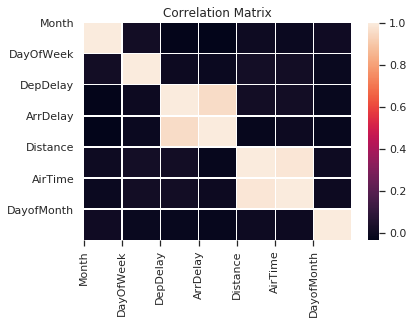

In [35]:
corr = corr_df.corr()
sns.heatmap(corr, linewidths=.25)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.title('Correlation Matrix')
plt.show()

There's nothing too surprising here; strong correlations are mostly between variables that depend on each other- such as distance and air time. One notable point is that there is a correlation between arrival delay and departure delay. This could prove useful when making arrival time predictions- we might use the departure time prediction as a feature in the arrival time prediction. 

## Building the Model

Now we can begin to build the model. As before, we're using the Keras API so we can export the models as `json` files and open them up with tensorflow.js in the browser.

In [10]:
import tensorflow as tf
from tensorflow import keras

Here's the functions to create the output classes as well as prepare the data by splitting into training and testing lists. Since the departure and delay times are continuous value, they need to be split into individual classes. We'll use two different classses: 0 for $x < 10$, and 1 for $x >= 10$. Note that we could easily add any number of possible classes, but for now we are interested in two cases; late and not late. We've set the definition of late to be +10 minutes relative to scheduled arrival or departure. 

In [11]:
classes = 2

def create_classes(y):
    for i in range(len(y)):
        if y[i] < 10:
            y[i] = 0
        else:
            y[i] = 1
    return y

def prepare_data(X, y):
    y = y.tolist()
    y = create_classes(y)
    return train_test_split(X, y, test_size=0.2, random_state=42)

### Departure Delays 

First, let's build a model of departure delays. We begin by selecting which parts of the dataframe to use as  features:

In [12]:
y = df['DepDelay']
X = df.drop(columns=['DepDelay', 'ArrDelay', 'Dest'])

Now we categorize and split the data:

In [13]:
X_train, X_test, y_train, y_test = prepare_data(X, y)

print(X_train[:5])

        Month  DayOfWeek  Reporting_Airline  Origin  DepTimeBlk  ArrTimeBlk
361473     11          5                  0      66           9          11
1361        5          6                 11     139          13          14
26999       5          5                 11     188           2           3
299190      5          7                  8      87           4           5
97552      12          2                  3     199          12          15


Now, the model. Previously we were using a regression model, but with a bit of tweaking we can make a classification model using the same keras `Sequential` model. Rather than a single value output, the new model uses a softmax layer to output two possible values for the two classes.

In [14]:
def build_classification_model(X_train):
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.sigmoid, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.sigmoid), 
    keras.layers.Dense(64, activation=tf.nn.sigmoid),
    keras.layers.Dense(classes, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

EPOCHS = 4

We can now build and train the model. We're just training for 4 epochs to get a sense of the accuracy.

In [15]:
model = build_classification_model(X_train)

history = model.fit(X_train, y_train, epochs=EPOCHS)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/4
446469/446469 [==============================] - 19s 42us/sample - loss: 0.5081 - acc: 0.7799
Epoch 2/4
446469/446469 [==============================] - 19s 42us/sample - loss: 0.5060 - acc: 0.7800
Epoch 3/4
446469/446469 [==============================] - 19s 43us/sample - loss: 0.5053 - acc: 0.7800
Epoch 4/4
446469/446469 [==============================] - 19s 42us/sample - loss: 0.5048 - acc: 0.7800


Now that the model is trained, we can check the accuracy on the test set. 

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Model accuracy on test data is {:2.2f}%'.format(100* test_acc))

111618/111618 [==============================] - 2s 17us/sample - loss: 0.5042 - acc: 0.7808
Model accuracy on test data is 78.08%


Not *fantastic* accuracy, but passable for the first try. Let's take a look at some of the predictions.

In [17]:
predictions = model.predict(X_test)

for index in range(5):
    print('Predicted class: {}'.format(np.argmax(predictions[index])))
    print('Real class: {}'.format(y_test[index]))

    print('{:2.0f}% chance correct\n'.format(100*np.max(predictions[index])))

Predicted class: 0
Real class: 0
73% chance correct

Predicted class: 0
Real class: 1
66% chance correct

Predicted class: 0
Real class: 0
73% chance correct

Predicted class: 0
Real class: 0
70% chance correct

Predicted class: 0
Real class: 0
72% chance correct



There appears to be some variation in the predicted probability for each guess being correct. Let's create two groups--right and wrong guesses--and create some statistics for each.

In [33]:
wrong_guesses = []
correct_guesses = []

for index in range(len(predictions)):
    if np.argmax(predictions[index]) != y_test[index]:
        wrong_guesses.append(np.max(predictions[index]))
    else:
        correct_guesses.append(np.max(predictions[index]))

print('Wrong guesses: avg {:2.0f}%, variance {:.3f}%'.format(100*np.mean(wrong_guesses), 100*np.var(wrong_guesses)))
print('Right guesses: avg {:2.0f}%, variance {:.3f}%'.format(100*np.mean(correct_guesses), 100*np.var(correct_guesses)))

Wrong guesses: avg 73%, variance 0.643%
Right guesses: avg 77%, variance 0.711%


The higher average for right guesses (77%) compared to wrong guesses (73%) is good, as it indicates that when the model makes a prediction with a higher probability it will more often be correct. 

Now we take a look at the distribution of correct and incorrect guesses and their related probabilities. 

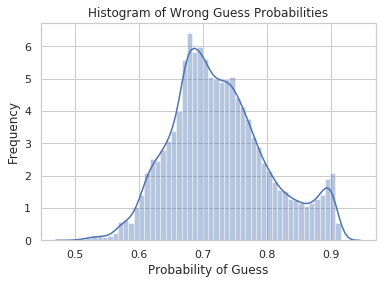

In [19]:
sns.distplot(wrong_guesses)
plt.title('Histogram of Wrong Guess Probabilities')
plt.xlabel('Probability of Guess')
plt.ylabel('Frequency')
plt.show()

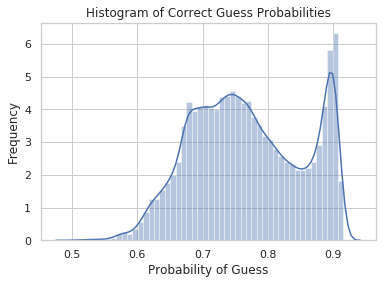

In [20]:
sns.distplot(correct_guesses)
plt.title('Histogram of Correct Guess Probabilities')
plt.xlabel('Probability of Guess')
plt.ylabel('Frequency')
plt.show()

These two histograms reiterate the above point, where correct guesses appear to have a relatively high number of guess probabilities around 0.9 and the remainder around 0.7-0.8. For the incorrect guesses, we see that the distribution is unimodal, centered around 0.7 with relatively few guesses around 0.9. This is what we want to see for this category, as the model is not producing particularily high guess probabilities for guesses that aren't accurate and is producing much higher guess probabilities to guesses that are correct. 

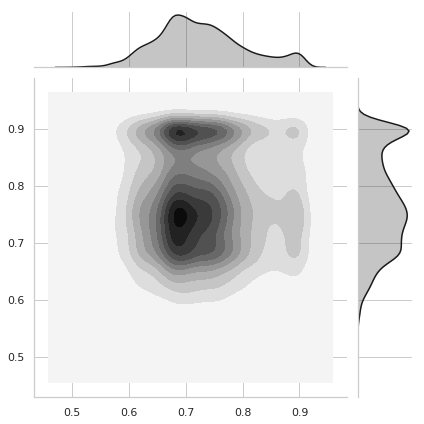

In [21]:
new_correct = np.split(correct_guesses, [len(wrong_guesses)])[0]

sns.jointplot(x=wrong_guesses, y=new_correct, kind='kde', color='k')

plt.show()

Overlaying the two histograms, it becomes clear that the correct guesses (Y axis) have a much higher concentration of probabilities around 0.9. Incorrect guesses (X axis) are more closely gathered around 0.7. Most guess probabilities seem to be in this area.

### Arrival Delays
 
Let's take a similar approach and create predictions of arrival delays, rather than departures. Let's revise and perhaps add some additional features to the model. At the moment, the origin and destination features are arbitrary numbers created by the encoder. We've created some more meaningful statistics that can be found on the [FlyGenius API](https://api.flygeni.us/docs) that might improve accuracy. In particular, each airline's percent ontime arrivals and departures, as well as each airport's percent ontime departures. We'll begin by adding airlines' percent ontime departures. 

First, we get the data from the API:

In [22]:
r = requests.get('https://api.flygeni.us/airports/?use_details=True')
airports = r.json()

r = requests.get('https://api.flygeni.us/airlines/?use_details=True')
airlines = r.json()

def get_airline_percent_ontime(id):
    for obj in airlines:
        if obj['airline_id'] == id:
            return obj['airline_percent_ontime_arrival']
        
def get_airport_percent_ontime(id):
    for obj in airports:
        if obj['airport_id'] == id:
            return obj['airport_percent_ontime_departure']


Now we encode the airline and origin fields with their respective statistics:

In [23]:
new_df = og_df.copy(deep=True)
new_df = encode(new_df, airline=False, origin=False, destination=False)

new_df['Reporting_Airline'] = new_df['Reporting_Airline'].map(lambda x: get_airline_percent_ontime(x))
new_df['Origin'] = new_df['Origin'].map(lambda x: get_airport_percent_ontime(x))
new_df['Dest'] = new_df['Dest'].map(lambda x: get_airport_percent_ontime(x))

Encoding departing time
Encoding arrival time


 Since these are arrival delays, there's an additional feature that can be used: the departure delay. In practice, we would not know if the flight departed late, but we can create two different predictions; one for the flight departing on time and another for the flight departing late. Let's create this new feature now.

In [28]:
y = new_df['ArrDelay']
X = new_df.drop(columns=['ArrDelay', 'ArrTimeBlk', 'DepTimeBlk', 'Dest'])

X['DepDelay'] = X['DepDelay'].map(lambda x: 0 if x < 15 else 1 )

X_train, X_test, y_train, y_test = prepare_data(X, y)

print(X_train[:5])

        Month  DayOfWeek  Reporting_Airline  Origin  DepDelay
361473     11          5                 80      82         0
1361        5          6                 78      74         1
26999       5          5                 78      83         0
299190      5          7                 80      88         0
97552      12          2                 85      77         0


Now we can build and train the model:

In [29]:
model = build_classification_model(X_train)

history = model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/4
446469/446469 [==============================] - 19s 44us/sample - loss: 0.3146 - acc: 0.9039
Epoch 2/4
446469/446469 [==============================] - 19s 43us/sample - loss: 0.3044 - acc: 0.9086
Epoch 3/4
446469/446469 [==============================] - 19s 43us/sample - loss: 0.3040 - acc: 0.9086
Epoch 4/4
446469/446469 [==============================] - 19s 43us/sample - loss: 0.3040 - acc: 0.9086


In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Model accuracy on test data is {:2.2f}%'.format(100* test_acc))

111618/111618 [==============================] - 2s 19us/sample - loss: 0.3048 - acc: 0.9079
Model accuracy on test data is 90.79%


With just a few tweaks, we gain over 10% in accuracy over the departure delay model. The last thing to do is visualize the prediction statistics with a confusion matrix.

In [ ]:
def create_confusion_matrix(model):
    predictions = model.predict(X_test)
    simplified_pred = []
    
    for index in range(len(predictions)):
        simplified_pred.append(np.argmax(predictions[index]))
    
    confusion = confusion_matrix(y_test, simplified_pred)
    
    sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Classes')
    plt.ylabel('Real Classes')
    plt.show()
    
    return simplified_pred

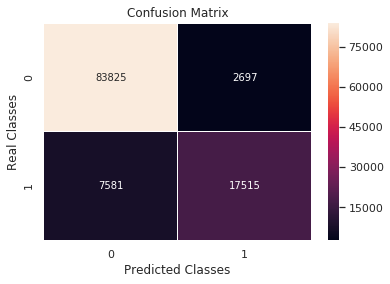

In [31]:
simplified_pred = create_confusion_matrix(model)

Let's take a look at how many the model correctly predicted of each class.

In [32]:
incorrect_1 = 0
incorrect_0 = 0
pred_1 = 0
pred_0 = 0

for index in range(len(simplified_pred)):
    if simplified_pred[index] == 1:
        pred_1 += 1
        if y_test[index] != 1:
            incorrect_1 += 1
        
    elif simplified_pred[index] == 0:
        pred_0 += 1
        if y_test[index] != 0:
            incorrect_0 += 1

print('Correctly guessed class 1 {:2.0f}% of the time'.format(100 * 1 - (pred_1 / incorrect_1)))
print('Correctly guessed class 0 {:2.0f}% of the time'.format(100 * 1 - (pred_0 / incorrect_0)))    

Correctly guessed class 1 93% of the time
Correctly guessed class 0 88% of the time


This indicates that the model is more accurate at predicting that a flight will be late (93%) than a flight will be on time (88%). So, the when the model predicts that a flight will arrive late, that is a fairly accurate prediction, which is a good thing. Both accuracy metrics are definitely high enough to work with, though there is always more that can be done. 

## Next Steps 

For this dataset, the next steps might include bringing in some historical weather data and using it as an additional feature. Additionally, we might also examine the reasons for delay a bit more, as weather is not the only cause. A delay of the flight before, for example, has an effect on the delay of the next flight. It could be possible to determine if the flight before arrived late by checking the airplane's tail number in the dataset. 


To see the model in action, head over to [FlyGenius](https://flygeni.us) and make some predictions!
